In this practical session we will answer questions about autoencoders and build one that compresses and reconstructs Fashion MNIST items.

![](images/autoencoder_schema.jpg)

Auto-encoders learn a *data-specific* compression function in an unsupervised manner. Depending on model complexity, autoencoders can generate very realistic reconstructions, but are always **lossy**. That is, some information about the original image will be lost.  

Auto-encoders are unsupervised. This is a very useful property. Why do you think so?

Mathematically, an autoencoder can be denoted as follows:

$$\hat{x} = d(e(x)) = d(z)$$

That is, it consists of an encoding function $e(x)$, a decoding function $d(z)$, where $z \in \mathbb{R}^d$ is some compressed state of $x$. Note that in all previous sessions we denoted our model output as $\hat{y}$. This time we do not, since our metric function will be one that compares $\hat{x}$ (our reconstructed image) to $x$ (the original image) instead of a target vector $y$.

If we parameterize $d$ and $e$ as neural networks, and use some differentiable loss function that compares the quality of the original input to the reconstructed input, we can simply use backpropagation to optimize!

Autoencoders are mainly used for three tasks:

* If we add stochasticity (Variational Auto Encoder) we can sample new datapoints.
* We can visualize our data distribution more clearly using the compressed representation. Simpler algorithms (T-SNE, PCA) might fall short here.

![](images/compression.png)
* We can use it for denoising our data. Which we will do in this session.

The following picture shows an autoencoder in the style that we visualized neural networks before.

![](images/autoencoder_neurons.png)

Let's build one using keras!

In [1]:
library(keras)
source("06-helpers.R")

use_multi_cpu()

data <- dataset_fashion_mnist()
data_train <- data$train
data_test <- data$test

Let's start with the preprocessing. Note that we don't need the labels this time. Try to do the following steps with the dataset:

* Extract the training and testing images.
* Normalize them.
* Part a slice of the training data for validation.

If you can't remember how to do these steps, try looking at notebook 03b!

In [2]:
x_train <- data_train$x / 255
x_test <- data_test$x / 255


x_train <- array_reshape(x_train, c(60000, 28*28))
x_test <- array_reshape(x_test, c(10000, 28*28))


index <- 0.8 * dim(x_train)[1]
x_val <- x_train[-(1:index),]
x_train <- x_train[1:index,]

Let's continue with constructing the autoencoder model. As can be seen from the previous image, an autoencoder can be constructed using a single sequence of operations. 

This time, we only provide the bare skeleton of the model. Try using hidden dimensions of 8 neurons and a latent dimension (that is, the dimensionality of the vector that the encoder outputs) of 4 neurons. Use ReLU activation for the intermediate layers, and sigmoid activation at the final output.

Why do you think we need sigmoid activation at the end?

In [3]:
model <- keras_model_sequential() %>%
    layer_dense(units = 8, input_shape = c(28*28)) %>%
    layer_activation_relu() %>%
    layer_dense(units = 4) %>%
    layer_activation_relu() %>%
    layer_dense(units=8) %>%
    layer_activation_relu() %>%
    layer_dense(units=784, activation='sigmoid')


cat(summary(model))

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 8)                       6280        
________________________________________________________________________________
re_lu (ReLU)                        (None, 8)                       0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 4)                       36          
________________________________________________________________________________
re_lu_1 (ReLU)                      (None, 4)                       0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 8)                       40          
________________________________________________________________________________
re_lu_2 

What makes up the difference between the encoding parameters and the decoding parameters?

ANSWER: the bias neurons.

Let's compile the model. Use `adam` as the optimizer with learning rate `0.01`. Next, use the `binary_crossentropy` loss function. That is, we treat every output neuron as a Bernoulli distribution with parameter $p$ and compare the original an reconstructed distributions.

In [4]:
model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "binary_crossentropy",
)



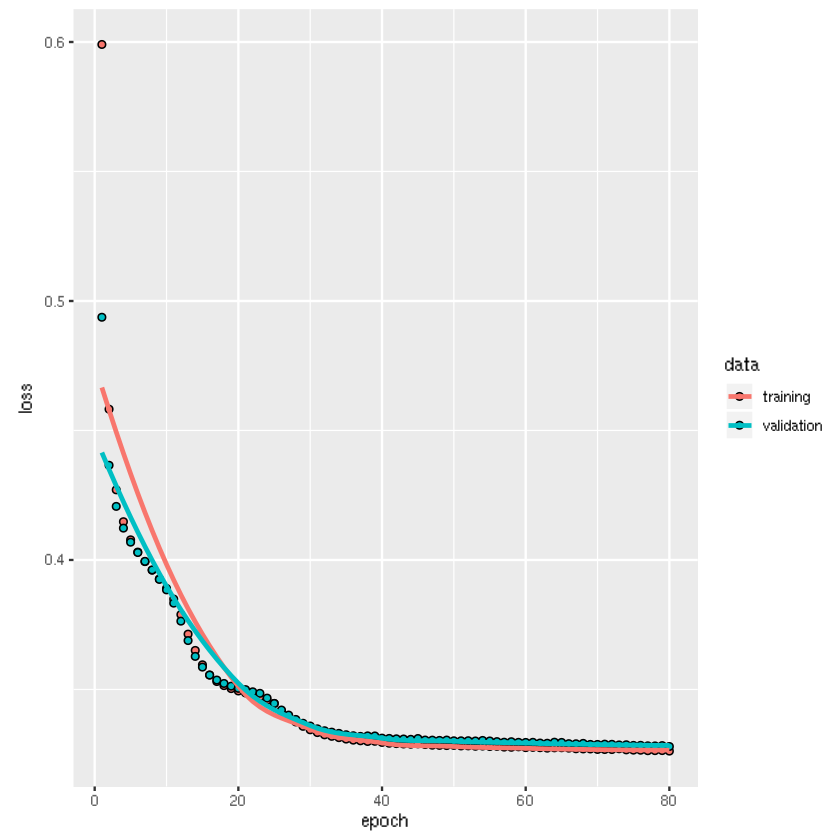

In [5]:
history <- model %>% fit(
    x = x_train,
    y = x_train,
    validation_data = list(x_val, x_val),
    epochs = 80,
    batch_size = 4096,
    callbacks=list(Progress$new())
)
plot(history)

Let's see what we have generated!

In [6]:
to_predict <- x_test[1:10,]

predictions <- model %>% predict(to_predict, batch_size = 1)
predictions <- array_reshape(predictions, c(10, 28, 28))

index <- 2

Change this index to compare different images.

Original:

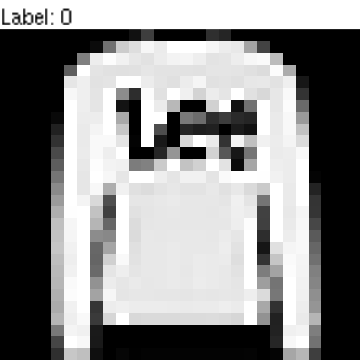

In [7]:
library(ggplot2)
library(reshape2)


options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(melt(t(apply(array_reshape(to_predict[index,], c(28, 28)), 2, rev)), varnames=c('x', 'y')), aes(x=x, y=y, fill=value)) +
    geom_raster() +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_gradient(low="#000000", high="#FFFFFF") +
    theme_void() +
    theme(legend.position = "none") +
    ggtitle(paste('Label:', x_test[index]))
options(repr.plot.width = 6, repr.plot.height = 5)

Generated:

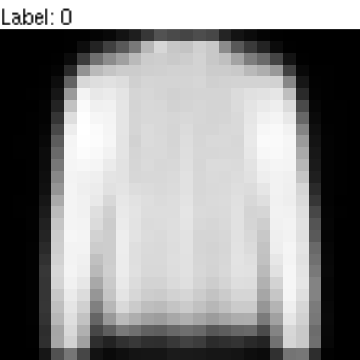

In [8]:
library(ggplot2)
library(reshape2)

options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(melt(t(apply(predictions[index,,], 2, rev)), varnames=c('x', 'y')), aes(x=x, y=y, fill=value)) +
    geom_raster() +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_gradient(low="#000000", high="#FFFFFF") +
    theme_void() +
    theme(legend.position = "none") +
    ggtitle(paste('Label:', x_test[index]))
options(repr.plot.width = 6, repr.plot.height = 5)

It seems like the model is trying, but the reconstructions aren't of high quality... Try to beef up the network by increasing the amount of layers, layer sizes and latent space.

In [9]:
model <- keras_model_sequential() %>%
    layer_dense(units = 128, input_shape = c(28*28)) %>%
    layer_activation_relu() %>%
    layer_dense(units = 64) %>%
    layer_activation_relu() %>%
    layer_dense(units = 32) %>%
    layer_activation_relu() %>%
    layer_dense(units=64) %>%
    layer_activation_relu() %>%
    layer_dense(units=128) %>%
    layer_activation_relu() %>%
    layer_dense(units=784, activation='sigmoid')


cat(summary(model))

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_4 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
re_lu_3 (ReLU)                      (None, 128)                     0           
________________________________________________________________________________
dense_5 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
re_lu_4 (ReLU)                      (None, 64)                      0           
________________________________________________________________________________
dense_6 (Dense)                     (None, 32)                      2080        
________________________________________________________________________________
re_lu_

In [10]:
model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "binary_crossentropy",
)

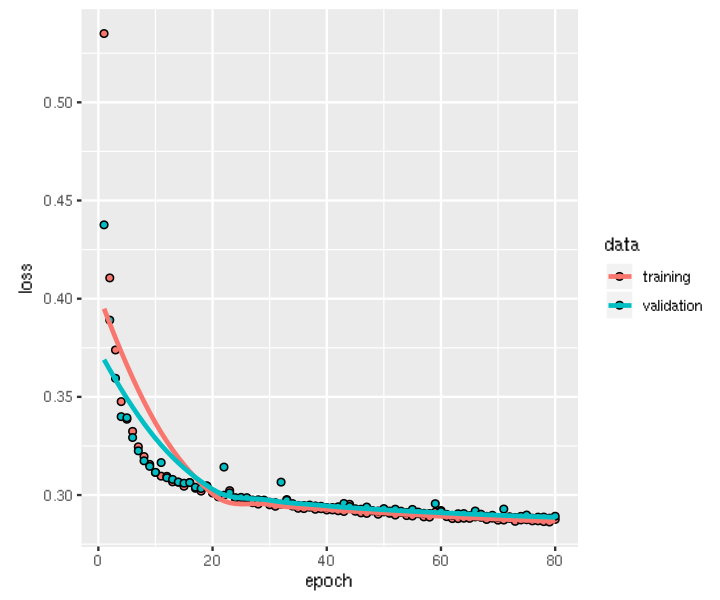

In [11]:
history <- model %>% fit(
    x = x_train,
    y = x_train,
    validation_data = list(x_val, x_val),
    epochs = 80,
    batch_size = 4096,
    callbacks=list(Progress$new())
)
plot(history)

Let's see if we improved.

In [12]:
to_predict <- x_test[1:10,]

predictions <- model %>% predict(to_predict, batch_size = 1)
predictions <- array_reshape(predictions, c(10, 28, 28))

index <- 2

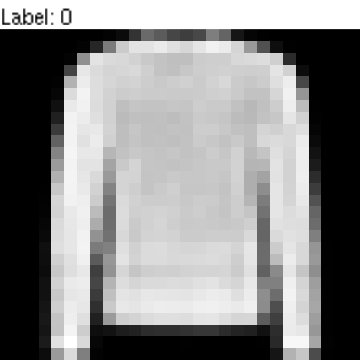

In [13]:
library(ggplot2)
library(reshape2)

options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(melt(t(apply(predictions[index,,], 2, rev)), varnames=c('x', 'y')), aes(x=x, y=y, fill=value)) +
    geom_raster() +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_gradient(low="#000000", high="#FFFFFF") +
    theme_void() +
    theme(legend.position = "none") +
    ggtitle(paste('Label:', x_test[index]))
options(repr.plot.width = 6, repr.plot.height = 5)

Looks a bit better!

## Denoising Autoencoder

Autoencoders can be used to denoise data. 'Noise' can be loosely interpreted. In fact, we can alter the original data with almost any transformation and recover the originals. For example, you could manually turn colored images into grayscale, and train an autoencoder to reverse this. After the model has converged, you could use the model to colorize old grayscale photos!

Since we are dealing with grayscale data here, we will focus on denoising.

Generate Gaussian noise vectors for train, validation and test using the `rnorm` function. Use a standard deviation of 1. Reshape these vectors into the same shape as train, validation and test data using `array_reshape`.

In [14]:
noise_train <- array_reshape(0.1 * rnorm(48000 * 28 * 28), c(dim(x_train)))
noise_val <- array_reshape(0.1 * rnorm(12000 * 28 * 28), c(dim(x_val)))
noise_test <- array_reshape(0.1 * rnorm(10000 * 28 * 28), c(dim(x_test)))

In [15]:
x_train_noisy <- x_train + noise_train
x_val_noisy <- x_val + noise_val
x_test_noisy <- x_test + noise_test

# We make sure max and min values are within the valid image range.
x_train_noisy[x_train_noisy > 1] = 1
x_train_noisy[x_train_noisy < 0] = 0

x_val_noisy[x_val_noisy > 1] = 1
x_val_noisy[x_val_noisy < 0] = 0

x_test_noisy[x_test_noisy > 1] = 1
x_test_noisy[x_test_noisy < 0] = 0


Create a denoising autoencoder model. You could use the same architecture as in the previous exercise.

In [16]:
model <- keras_model_sequential() %>%
    layer_dense(units = 128, input_shape = c(28*28)) %>%
    layer_activation_relu() %>%
    layer_dense(units = 64) %>%
    layer_activation_relu() %>%
    layer_dense(units = 32) %>%
    layer_activation_relu() %>%
    layer_dense(units=64) %>%
    layer_activation_relu() %>%
    layer_dense(units=128) %>%
    layer_activation_relu() %>%
    layer_dense(units=784, activation='sigmoid')


cat(summary(model))

Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_10 (Dense)                    (None, 128)                     100480      
________________________________________________________________________________
re_lu_8 (ReLU)                      (None, 128)                     0           
________________________________________________________________________________
dense_11 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
re_lu_9 (ReLU)                      (None, 64)                      0           
________________________________________________________________________________
dense_12 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
re_lu_

In [17]:
model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "binary_crossentropy",
)

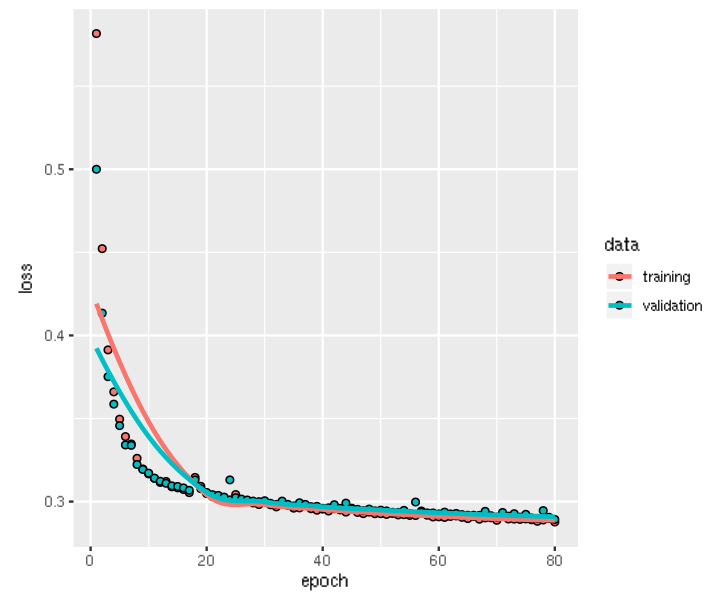

In [18]:
history <- model %>% fit(
    x = x_train_noisy,
    y = x_train,
    validation_data = list(x_val_noisy, x_val),
    epochs = 80,
    batch_size = 4096,
    callbacks=list(Progress$new())
)
plot(history)

Let's take a look at the results.

In [19]:
to_predict <- x_test_noisy[1:10,]

predictions <- model %>% predict(to_predict, batch_size = 1)
predictions <- array_reshape(predictions, c(10, 28, 28))

index <- 4

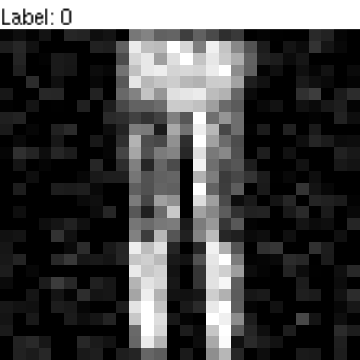

In [20]:
library(ggplot2)
library(reshape2)


options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(melt(t(apply(array_reshape(to_predict[index,], c(28, 28)), 2, rev)), varnames=c('x', 'y')), aes(x=x, y=y, fill=value)) +
    geom_raster() +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_gradient(low="#000000", high="#FFFFFF") +
    theme_void() +
    theme(legend.position = "none") +
    ggtitle(paste('Label:', x_test[index]))
options(repr.plot.width = 6, repr.plot.height = 5)

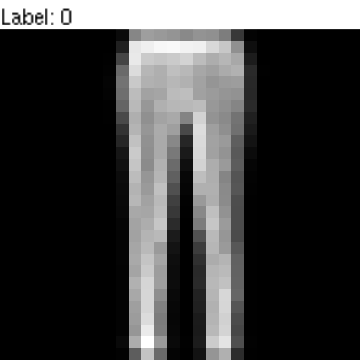

In [21]:
library(ggplot2)
library(reshape2)

options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(melt(t(apply(predictions[index,,], 2, rev)), varnames=c('x', 'y')), aes(x=x, y=y, fill=value)) +
    geom_raster() +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_gradient(low="#000000", high="#FFFFFF") +
    theme_void() +
    theme(legend.position = "none") +
    ggtitle(paste('Label:', x_test[index]))
options(repr.plot.width = 6, repr.plot.height = 5)

We've effectively removed the noise! 

As you might expect, this is partly due to the fact that our model is not complex enough to learn even the text on the shirt (index 2). In the bonus sections we will try to tackle this.

In the bonus sections we will try to tackle this.

## Bonus 1: Going convolutional

In the presentations we have seen that convolutional neural networks (CNNs) can be extremely powerful for image data. Let's change our network by using convolutions and increasing the parameters to generate images of higher quality.


First, we reshape the data such that it is compatible with a convolutional approach.


In [22]:
x_train <- array_reshape(x_train, c(48000, 28, 28, 1))
x_val <- array_reshape(x_val, c(12000, 28, 28, 1))
x_test <- array_reshape(x_test, c(10000, 28, 28, 1))


In [23]:
noise_train <- array_reshape(0.1 * rnorm(48000 * 28 * 28), c(48000, 28, 28, 1))
noise_val <- array_reshape(0.1 * rnorm(12000 * 28 * 28), c(12000, 28, 28, 1))
noise_test <- array_reshape(0.1 * rnorm(10000 * 28 * 28), c(10000, 28, 28, 1))

In [24]:
x_train_noisy <- x_train + noise_train
x_val_noisy <- x_val + noise_val
x_test_noisy <- x_test + noise_test


x_train_noisy[x_train_noisy > 1] = 1
x_train_noisy[x_train_noisy < 0] = 0

x_val_noisy[x_val_noisy > 1] = 1
x_val_noisy[x_val_noisy < 0] = 0

x_test_noisy[x_test_noisy > 1] = 1
x_test_noisy[x_test_noisy < 0] = 0

Create the Convolutional Autoencoder model. Use two convolutional layers `layer_conv_2d` with 32 filters, kernel sizes of 3, 'SAME' padding and ReLU activation. After each convolutional layer use a `layer_average_pooling_2d` layer to reduce the spatial dimensionality. Then flatten the activations using `layer_flatten` and map to a dense vector with dimensionality 64. 

Try to 'mirror' the encoder into a decoder (e.g. the amount of layers and parameters should be roughly the same), using `layer_upsamlpling_2d` instead of average pooling.

Your final layer should be a convolutional layer with 1 filter and sigmoid activation.

In [25]:
model_cnn <- keras_model_sequential() %>%
        layer_conv_2d(filters = 32, kernel_size=3,input_shape = c(28, 28, 1), padding='SAME') %>%
        layer_activation_relu() %>%
        layer_average_pooling_2d() %>%
        layer_conv_2d(filters = 32, kernel_size=3, padding='SAME') %>%
        layer_activation_relu() %>%
        layer_average_pooling_2d() %>%
        layer_flatten() %>%
        layer_dense(units = 64) %>%
        layer_activation_relu() %>%
        layer_dense(units = 7 * 7 * 32) %>%
        layer_activation_relu() %>%
        layer_reshape(target_shape = c(7, 7, 32)) %>%
        layer_upsampling_2d() %>%
#         layer_zero_padding_2d(padding = list(list(0, 1), list(0, 1))) %>%
        layer_conv_2d(filters=32, kernel_size=3, padding='SAME') %>%
        layer_activation_relu() %>%
        layer_upsampling_2d() %>%
        layer_conv_2d(filters=1, kernel_size=3, padding='SAME', activation='sigmoid')
cat(summary(model_cnn))

Model: "sequential_3"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 28, 28, 32)              320         
________________________________________________________________________________
re_lu_13 (ReLU)                     (None, 28, 28, 32)              0           
________________________________________________________________________________
average_pooling2d (AveragePooling2D (None, 14, 14, 32)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 14, 14, 32)              9248        
________________________________________________________________________________
re_lu_14 (ReLU)                     (None, 14, 14, 32)              0           
________________________________________________________________________________
averag

In [26]:
model_cnn %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "binary_crossentropy",
)



Because of the 'heavy' network, we reduce epochs and batch size. ß

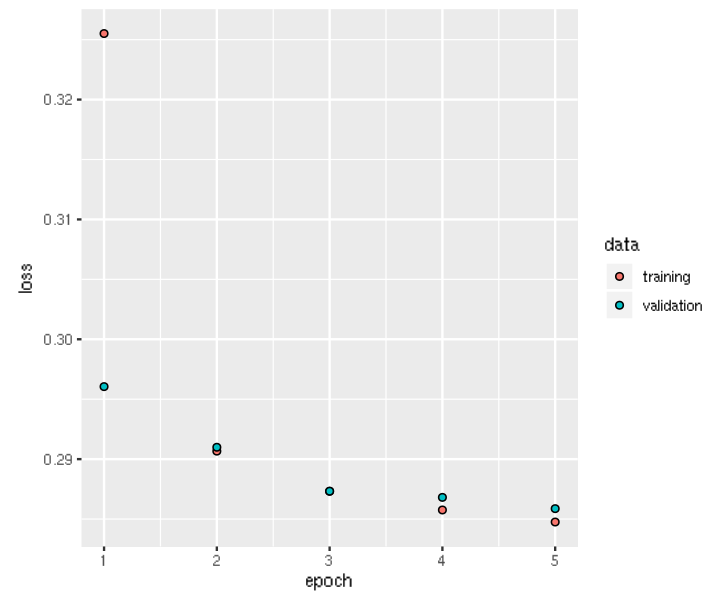

In [27]:
history <- model_cnn %>% fit(
    x = x_train_noisy,
    y = x_train,
    validation_data = list(x_val_noisy, x_val),
    epochs = 5,
    batch_size = 64,
    callbacks=list(Progress$new())
)
plot(history)

In [28]:

to_predict <- array_reshape(x_test_noisy[1:10,,,], c(10, 28, 28, 1))
predictions <- model_cnn %>% predict(to_predict, batch_size = 1)
predictions <- array_reshape(predictions, c(10, 28, 28))


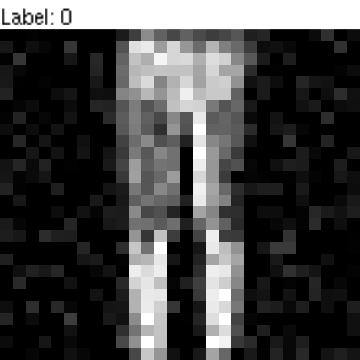

In [29]:
library(ggplot2)
library(reshape2)
index=4

options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(melt(t(apply(to_predict[index,,,], 2, rev)), varnames=c('x', 'y')), aes(x=x, y=y, fill=value)) +
    geom_raster() +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_gradient(low="#000000", high="#FFFFFF") +
    theme_void() +
    theme(legend.position = "none") +
    ggtitle(paste('Label:', x_test[index]))
options(repr.plot.width = 6, repr.plot.height = 5)

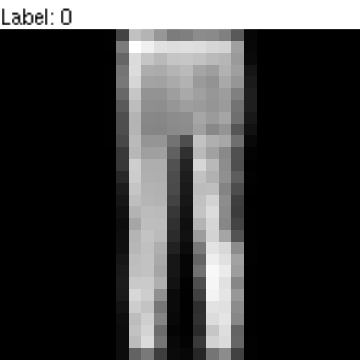

In [30]:
library(ggplot2)
library(reshape2)

options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(melt(t(apply(predictions[index,,], 2, rev)), varnames=c('x', 'y')), aes(x=x, y=y, fill=value)) +
    geom_raster() +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_fill_gradient(low="#000000", high="#FFFFFF") +
    theme_void() +
    theme(legend.position = "none") +
    ggtitle(paste('Label:', x_test[index]))
options(repr.plot.width = 6, repr.plot.height = 5)

Very nice! This network could probably become much better if we weren't computationally constrained.

## Bonus 2:

Try using BatchNormalization to speed up training.